### Library

In [1]:
import requests
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt

### Request data

In [2]:
URL = 'https://www.fundsexplorer.com.br/ranking'
resposta = requests.get(URL)

if resposta.status_code == 200:
  data = pd.read_html(resposta.content, encoding = 'utf-8')[0]

data.sort_values('Códigodo fundo', inplace = True)
#data

### Displaying the dataframe and informations

In [3]:
#data.describe(include='all')
#data['Setor'].unique()
#data.columns

### Rename columns

In [4]:
data.columns = [
    'Ticker', 'Sector', 'Price', 'Daily liquidity',
       'Dividend', 'DY', '3m DY acc.', '6m DY acc.',
       '12m DY acc.', 'DY 3m', 'DY 6m', 'DY 12m',
       'DY year', 'Price Variation', 'Rent. of period', 'Rent. acc.',
       'Patrimonio_liquido', 'VPA', 'P/BV', 'DY patrimonial',
       'Variacao patrimonial', 'Rentab patrimonial no periodo',
       'Rentabilidade patrimonial acumulada', 'Vacancy', 'Vacancia financeira',
       'Qty of assets'
]

### Columns of interest

In [5]:
selectioned = ['Ticker', 'Sector', 'Price', 'Vacancy', '3m DY acc.', '6m DY acc.', '12m DY acc.', 'P/BV', 'Qty of assets', 'Daily liquidity']                     

data = data[selectioned]

## Cleaning the data

In [6]:
data.isnull().sum()

Ticker               0
Sector               5
Price                8
Vacancy            160
3m DY acc.           6
6m DY acc.           6
12m DY acc.          6
P/BV                 8
Qty of assets        0
Daily liquidity      8
dtype: int64

In [7]:
setor_null = data[data['Sector'].isna()].index
data.drop(setor_null, inplace=True)
#data
#data.info()

## Fill out value zero at NAN

In [8]:
columns_floats = list(data.iloc[:,2:-1])
data[columns_floats] = data[columns_floats].fillna(value = 0)
#data.info()

## Treating Columns with float numbers

In [9]:
data[columns_floats] = data[columns_floats].applymap(lambda x: str(x).replace('R$ ', '').replace('.0','').replace('%','').replace('.','').replace(',','.'))
data[columns_floats] = data[columns_floats].astype('float')
#data.info()
#data.describe().T

In [10]:
#data['P-VPA']

In [11]:
data['P/BV'] = data['P/BV']/100
#data.describe().T


## Metrics

In [12]:
metrics_sector = data.groupby('Sector').agg(['mean', 'std'])
#metrics_setor

C:\Users\anaco\AppData\Local\Temp/ipykernel_14496/2369199609.py:1: FutureWarning: ['Ticker'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  metrics_sector = data.groupby('Sector').agg(['mean', 'std'])


In [13]:
#metrics_setor.loc['Logística', ('DY 12m acc.', 'mean')]


## Strategy Function

In [14]:
def filtrar(data, sector, label_sector='Sector'):
    metrics_sector = data.groupby('Sector').agg(['mean', 'std'])

    df_sector = data[data[label_sector].isin([sector])]

    if sector == 'Títulos e Val. Mob.':
        filtro_ = \
            (df_sector['P/BV'] < 0.9) & \
            (df_sector['P/BV'] > .50) & \
            (df_sector['12m DY acc.'] > metrics_sector.loc[sector, ('12m DY acc.', 'mean')]) & \
            (df_sector['Daily liquidity'] >= metrics_sector.loc[sector, ('Daily liquidity', 'mean')])

    else:
        filtro_ = \
            (df_sector['Qty of assets'] > 5) & \
            (df_sector['P/BV'] < 0.9) & \
            (df_sector['P/BV'] > .50) & \
            (df_sector['12m DY acc.'] > metrics_sector.loc[sector, ('12m DY acc.', 'mean')]) & \
            (df_sector['Daily liquidity'] >= metrics_sector.loc[sector, ('Daily liquidity', 'mean')]) 
    
    print('Sector Yield mean: {}'.format(metrics_sector.loc[sector, ('12m DY acc.','mean')]))
    print('Sector P/VPA mean: {}'.format(metrics_sector.loc[sector, ('P/BV','mean')]))
    print('Sector Qty of assets mean: {}'.format(metrics_sector.loc[sector, ('Qty of assets','mean')]))


    return df_sector[filtro_]

In [15]:
data['Sector'].unique()
data['Sector'] = data['Sector'].replace({'Lajes Corporativas': 'Corporate','Shoppings': 'Commercial','Logística': 'Logistics',
                                         'Títulos e Val. Mob.': 'FOF','Híbrido': 'Hybrid','Residencial': 'Residential','Outros': 'Others'})
#data

In [16]:
filtro_lajes = filtrar(data, sector='Corporate')
filtro_lajes.sort_values('12m DY acc.', ascending=False, inplace=True)
filtro_lajes


Sector Yield mean: 6.862439024390245
Sector P/VPA mean: 0.6970731707317073
Sector Qty of assets mean: 4.097560975609756


C:\Users\anaco\AppData\Local\Temp/ipykernel_14496/2370640572.py:2: FutureWarning: ['Ticker'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  metrics_sector = data.groupby('Sector').agg(['mean', 'std'])
C:\Users\anaco\AppData\Local\Temp/ipykernel_14496/2891030146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtro_lajes.sort_values('12m DY acc.', ascending=False, inplace=True)


,Ticker,Sector,Price,Vacancy,3m DY acc.,6m DY acc.,12m DY acc.,P/BV,Qty of assets,Daily liquidity
122,BBPO11,Corporate,79.37,0.00,3.33,6.35,11.76,0.79,64.0,25367.0
188,VINO11,Corporate,43.84,4.20,2.23,4.33,9.80,0.81,9.0,28116.0
213,HGRE11,Corporate,124.50,27.13,1.83,3.53,8.24,0.77,21.0,11929.0


# Ranking of REITs

In [17]:
# Mínimo 5 ativos.
Ranking_REITS = data[data['Qty of assets'] >= 5]
Ranking_REITS

,Ticker,Sector,Price,Vacancy,3m DY acc.,6m DY acc.,12m DY acc.,P/BV,Qty of assets,Daily liquidity
111,ALZR11,Logistics,112.13,0.00,2.03,4.02,7.63,1.03,15.0,8332.0
122,BBPO11,Corporate,79.37,0.00,3.33,6.35,11.76,0.79,64.0,25367.0
165,BBRC11,Others,98.01,5.37,2.99,5.86,11.09,0.92,20.0,452.0
196,BNFS11,Others,117.00,0.00,3.65,6.87,12.79,1.18,18.0,634.0
36,BPML11,Commercial,62.12,5.80,0.95,2.59,0.00,0.49,7.0,110.0
205,BRCO11,Logistics,100.00,0.00,2.09,3.99,7.68,0.84,10.0,19024.0
37,BRCR11,Hybrid,57.77,21.00,2.22,4.38,8.35,0.57,15.0,33065.0
277,BREV11,Hybrid,93.50,0.00,1.82,3.58,6.91,0.85,12.0,7.0
114,BTAL11,Others,94.86,0.00,2.58,5.09,10.05,0.89,7.0,10348.0
105,BTLG11,Logistics,100.20,0.00,2.25,4.35,8.45,1.01,16.0,49473.0


In [18]:
graph1A = Ranking_REITS.sort_values('P/BV', ascending=False)
graph1A = graph1A.head(20)
#graph1A

## Plot de Grafico - Ranking FIIs mais baratos de acordo com P/VPA.


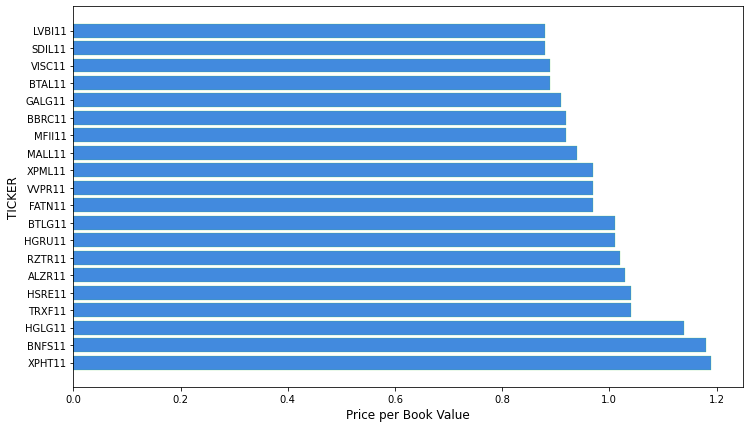

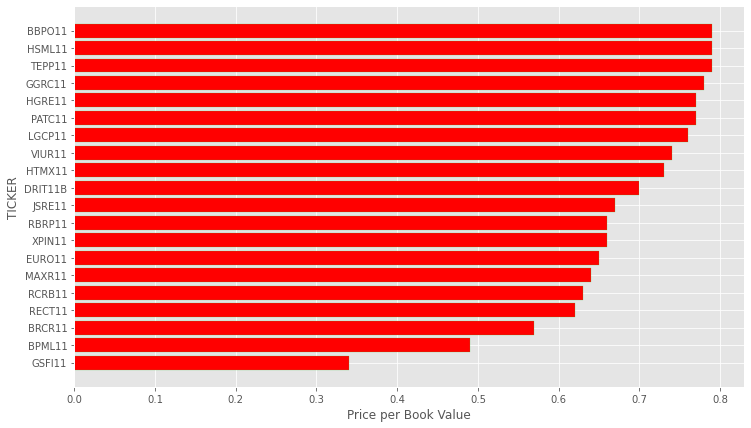

In [19]:
y1 = graph1A['P/BV']

x1 = graph1A['Ticker']

fig1 = plt.figure(figsize=(12, 7))
plt.barh(x1, y1, color='#428ADE', edgecolor='limegreen', linewidth=.2)
plt.ylabel('TICKER', fontsize=12)
plt.xlabel('Price per Book Value', fontsize=12)
plt.rcParams.update({'font.size': 10})
plt.style.use('ggplot')
plt.show(fig1)



graph1B = Ranking_REITS.sort_values('P/BV', ascending=True)

graph1B = graph1B.head(20)

y1 = graph1B['P/BV']

x1 = graph1B['Ticker']

fig2 = plt.figure(figsize=(12, 7))

plt.barh(x1, y1, color='red', edgecolor='limegreen', linewidth=.2)
plt.ylabel('TICKER', fontsize=12)
plt.xlabel('Price per Book Value', fontsize=12)
plt.rcParams.update({'font.size': 10})
plt.style.use('ggplot')
plt.show(fig2)
